# Preliminary Setting

## R Setting

In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(tidyverse)
library(grDevices)
library(showtext)
library(ggforce)
library(ggpubr)
library(sjPlot)
library(WRS2)
library(psych)
library(purrr)
library(effectsize)
library(grDevices)
library(optimx)
library(car)
library(lme4)
library(extrafont)

font_add_google(
    name='Source Serif 4',
    family='ssp',
    db_cache=FALSE
)

font_add(
    family='Times New Roman',
    regular='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf',
    bold='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf'
)
    
showtext_auto()

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='Times New Roman',
) + theme(
        axis.title.x=element_text(colour='grey20', size=10, face='bold'),
        axis.title.y=element_text(colour='grey20', size=10, face='bold'),
        axis.text.x=element_text(colour='grey20', size=10),
        axis.text.y=element_text(colour='grey20', size=10),
        strip.text.x=element_text(colour='grey20', size=10, face='bold'),
        strip.text.y=element_text(colour='grey20', size=10, face='bold'),
        legend.title=element_text(colour='grey20', size=10, face='bold'),
        legend.text=element_text(colour='grey20', size=10),
        legend.position='top',
        legend.box.spacing= unit(0, 'cm')
    )

## Utility Functions

In [4]:
import pytz
import pickle
import ray
import warnings
from datetime import datetime
import mitosheet
import pandas as pd
import numpy as np
import scipy.stats as st
from functools import wraps


DEFAULT_TZ = pytz.FixedOffset(540)  # GMT+09:00; Asia/Seoul


def load(path: str):
    with open(path, mode='rb') as f:
        return pickle.load(f)

    
def dump(obj, path: str):
    with open(path, mode='wb') as f:
        pickle.dump(obj, f)
        
    
def log(msg: any):
    print('[{}] {}'.format(datetime.now().strftime('%y-%m-%d %H:%M:%S'), msg))

    
def show(d: pd.DataFrame):
    return mitosheet.sheet(d)


def stat(x):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        m = np.mean(x)
        s = np.std(x, ddof=1)
        l, u = st.t.interval(0.95, len(x) - 1, loc=np.mean(x), scale=st.sem(x))
        med = np.median(x)
        q_1, q_3 = np.quantile(x, [0.25, 0.75])
        iqr = (q_3 - q_1) * 1.5
    
        return m, s, l, u, med, q_1 - iqr, q_3 + iqr


def on_ray(*args, **kwargs):
    try:
        if ray.is_initialized():
            ray.shutdown()
        ray.init(*args, **kwargs)
        yield None
    finally:
        ray.shutdown()
        
        
def str_to_datetime(x: pd.Series):
    return pd.to_datetime(x, format='%Y-%m-%d', utc=True).dt.tz_convert(DEFAULT_TZ)


def ms_to_datetime(x: pd.Series):
    return pd.to_datetime(x, unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)

ImportError: cannot import name 'DataError' from 'pandas.core.base' (/home/woohyeokchoi/miniconda3/envs/incentive/lib/python3.9/site-packages/pandas/core/base.py)

## Base Incentive

In [5]:
import numpy as np
from abc import abstractmethod
from typing import Dict, Optional


class BaseIncentive:
    def __init__(self, incentives: np.ndarray, random_state: int = None) -> None:
        self._incentives = np.asarray(incentives)
        self._random = np.random.default_rng(random_state)

    @abstractmethod
    def expect(self, incentive: float, context: any=None) -> float:
        pass

    @abstractmethod
    def choose(self, context: any=None) -> float:
        pass

    @abstractmethod
    def update(self, incentive: float, response: float, context: any=None) -> Optional[Dict[str, any]]:
        pass


# LR-based Incentive

* LR-based Incentive Estimation

$$y = \frac{1}{1 + e^{-(\beta_0 + \beta_1 r + B \cdot C)}}$$

* The amount of incentive is estimated by:
$$ r = \frac{1}{\beta_1}\big(\ln \frac{y}{1-y} - \beta_0 - B \cdot C \big) $$


* Where there are exceptions:
    * No intervention histories at all: default incentive
    * All success or negative $\beta_1$ (i.e., incentive make adherence worse rather): minimum incentive
    * All failures: maximum incentive

In [6]:
import numpy as np
from typing import Dict, Optional
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, log_loss


class LogisticRegressionIncentive(BaseIncentive):
    def __init__(
        self, 
        incentives: np.ndarray, 
        incentive_default: float, 
        expected_likelihood: float, 
        window_size: int,
        allow_exploration: bool = False,
        random_state: int = None
    ) :
        super().__init__(incentives, random_state)

        self._incentive_default = incentive_default
        self._expected_likelihood = expected_likelihood
        self._window_size = window_size
        self._allow_exploration = allow_exploration

        self._lr = None
        self._encoder = None
        self._histories = []
    
    
    @property
    def histories_(self):
        return self._histories[-self._window_size:] if self._window_size > 0 else self._histories
    
    @property
    def coef_incentive_(self):
        if self._lr:
            return np.ravel(self._lr.coef_)[0]
        else:
            return np.nan

    def expect(self, incentive: float, context: any = None) -> float:
        assert self._lr is not None
        assert self._encoder is not None        
        
        categories = self._encoder.categories_[0]
        if context not in categories:
            context = np.zeros((1, len(context)))
        else:
            context = self._encoder.transform(np.asarray([[context]], dtype=object))
        
        incentive = np.asarray([[incentive]])
        X = np.concatenate((incentive, context), axis=1)
        return np.ravel(self._lr.predict_proba(X=X)[:, 1]).item(0)

    def choose(self, context: any = None) -> float:
        if self._lr is None or self._encoder is None:
            responses = np.asarray([i for _, _, i in self.histories_])
            
            if len(responses) == 0:
                return self._incentive_default
            elif np.all(responses == 1.0):
                return np.min(self._incentives)
            elif np.all(responses == 0.0):
                return np.max(self._incentives)

        if self.coef_incentive_ < 1e-3:
            if self._allow_exploration:
                return self._random.choice(self._incentives)
            else:
                return np.min(self._incentives)
        probs = np.asarray([
            self.expect(incentive=incentive, context=context) for incentive in self._incentives
        ])
        diff = np.abs(probs - self._expected_likelihood)
        opt_incentives = self._incentives[np.where(diff == np.min(diff))]
        return self._random.choice(opt_incentives)

    def update(self, incentive: float, response: float, context: any = None) -> Optional[Dict[str, any]]:
        self._histories.append((context, incentive, response))

        histories = self.histories_
        responses = np.asarray([i for _, _, i in histories])
        
        if len(np.unique(responses)) == 1:
            return None

        contexts = np.asarray([[i] for i, _, _ in histories])
        incentives = np.asarray([[i] for _, i, _ in histories])

        self._encoder = OneHotEncoder(sparse=False, dtype=np.int32, drop=None).fit(contexts)

        X = np.concatenate((incentives, self._encoder.transform(contexts)), axis=1)
        self._lr = LogisticRegression(C=0.1, tol=1e-4, solver='lbfgs', penalty='l2').fit(X, responses)
        
        y_prob = self._lr.predict_proba(X)[:, 1]
        y_pred = self._lr.predict(X)

        return {'accuracy': accuracy_score(responses, y_pred), 'logloss': log_loss(responses, y_prob)}
    

## Toy example

In [7]:
SIGMOID = lambda beta, r_max, r_min, intercept, r: 1 / (1 + np.exp( intercept + (1 - 2 * beta * ( (r - r_min) / (r_max - r_min) ) ) * np.log(99)  ) )

In [8]:
import pandas as pd
from functools import partial


SIGMOID_DEFAULT = partial(SIGMOID, beta=1, r_max =10, r_min=0, intercept=0)
SIGMOID_LOW = partial(SIGMOID, beta=.75, r_max=10, r_min=0, intercept=0)
SIGMOID_HIGH = partial(SIGMOID, beta=2.0, r_max=10, r_min=0, intercept=0)

TOY_LR, TOY_BEHAVIOR = [], []
INC = np.arange(2, 21, 2)

for b, k in zip([SIGMOID_DEFAULT, SIGMOID_LOW, SIGMOID_HIGH], ['d', 'l', 'h']):
    ran = np.random.default_rng(14)

    lr = LogisticRegressionIncentive(
        incentives=np.arange(0, 11),
        incentive_default=5,
        expected_likelihood=.50,
        window_size=10,
        allow_exploration=False,
        random_state=None
    )
    
    for i in range(0, 20):
        inc = lr.choose()
        prob = b(r = inc)
        resp = 1 if ran.uniform() < prob else 0
        lr.update(inc, resp)
        
        TOY_LR.append({
            'rounds': i,
            'incentives': inc,
            'responses': resp,
            'name': k
        })
    
    for i in np.arange(0, 10, 0.1):
        TOY_BEHAVIOR.append({
            'incentives': i,
            'probabilities': b(r = i),
            'name': k
        })

TOY_LR = pd.DataFrame(TOY_LR)
TOY_BEHAVIOR = pd.DataFrame(TOY_BEHAVIOR)

/home/woohyeokchoi/miniconda3/envs/incentive/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/woohyeokchoi/miniconda3/envs/incentive/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/woohyeokchoi/miniconda3/envs/incentive/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/woohyeokchoi/miniconda3/envs/incentive/lib/python3.9/site-packages/sklearn/preprocess

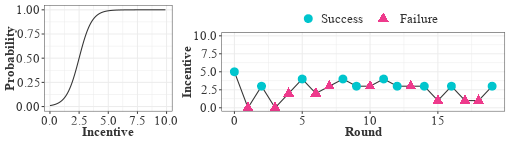

In [9]:
%%R -i TOY_BEHAVIOR -i TOY_LR -w 18 -h 5 -u cm

for (k in unique(TOY_BEHAVIOR$name)) {
    behavior <- TOY_BEHAVIOR %>% filter(name == k)
    
    lr <- TOY_LR %>% filter(
        name == k
    ) %>% mutate(
        y=as_factor(if_else(responses == 1, 'Success', 'Failure'))
    )

    p_behavior <- ggplot(behavior, aes(x=incentives, y=probabilities)) +
        geom_line(color='grey20') +
        THEME_DEFAULT +
        labs(
            x='Incentive',
            y='Probability'
        ) +
        scale_x_continuous(
            limits=c(0, 10)
        ) + 
        scale_y_continuous(
            limits=c(.0, 1.)
        ) +
        theme(
            legend.position='top',
            legend.title=element_blank(),
            legend.text=element_text(vjust=.6),
            legend.background=element_blank(),
        )
    
    p_lr <- ggplot(lr, aes(x=rounds, y=incentives)) +
        geom_line(color='grey20') +
        geom_point(size=3.5, alpha=1.0, aes(shape = y, colour = y)) +
        THEME_DEFAULT +
        labs(
            x='Round',
            y='Incentive',
            shape='Response',
            color='Response'
        ) +
        scale_y_continuous(
            limits=c(0, 10)
        ) + 
        scale_colour_manual(
            values=c('Success' = 'turquoise3', 'Failure' = 'violetred2'),
        ) + 
        scale_shape_manual(
            values=c('Success' = 'circle', 'Failure' = 'triangle'),
        ) + 
        theme(
            legend.position='top',
            legend.title=element_blank(),
            legend.text=element_text(vjust=.5, size=10),
            legend.spacing.x=unit(.4, 'cm'),
            legend.text.align=1,
            legend.background=element_blank(),
        )
    p <- ggarrange(p_behavior, p_lr, widths=c(.8, 1.5))
    ggsave(paste('./output/lr-toy-example-estimation-', k, '.pdf', sep=''), plot=p, width=18, height=5, units='cm', device=cairo_pdf)
    print(p)
}

In [37]:
import pandas as pd
import numpy as np



def ran(r, p):
    if 0 <= r < 2:
        return p[0]
    elif 2 <= r < 4:
        return p[1]
    elif 4 <= r < 6:
        return p[2]
    elif 6 <= r < 8:
        return p[3]
    else:
        return p[4]


data = []

for ii in range(10):
    rand = np.random.default_rng().uniform(0, 1, 5)
    
    for i in np.arange(10, step=0.01):
        data.append({
            'x': i,
            'p': ran(i, rand),
            'ii': str(ii)
        })
data = pd.DataFrame(data)

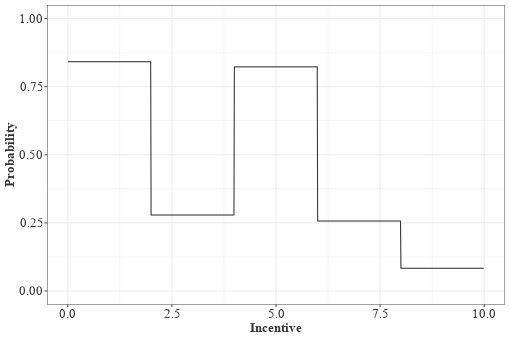

In [49]:
%%R -i data -i TOY_LR -w 18 -h 12 -u cm



for (i in c('0', '1', '2', '4', '5')) {

    p <- ggplot(data %>% filter(ii == i), aes(x=x, y=p)) +
        geom_line(color='grey20') +
        THEME_DEFAULT +
        labs(
            x='Incentive',
            y='Probability'
        ) +
        scale_x_continuous(
            limits=c(0, 10)
        ) + 
        scale_y_continuous(
            limits=c(.0, 1.)
        ) +
        THEME_DEFAULT
    ggsave(paste(i, '.pdf', sep=''), plot=p, width=8, height=6, units='cm')
    print(p)
}

## Data Preparation

In [9]:
import pandas as pd


SUBJECTS = pd.read_csv('./data/lr/subjects.csv').assign(
    age=lambda x: (2020 - x['birthyear'])
)

show(SUBJECTS)

MitoWidget(analysis_data_json='{"analysisName": "id-qxpksskipn", "analysisToReplay": null, "code": [], "stepSu…

In [10]:
import pandas as pd


EVENTS = pd.read_csv('./data/lr/events.csv').merge(
    SUBJECTS[['pid', 'group', 'start_date']],
    how='left',
    left_on='pid',
    right_on='pid',
).assign(
    days=lambda x: (ms_to_datetime(x['start_time']) - str_to_datetime(x['start_date'])).dt.days
)

show(EVENTS)

MitoWidget(analysis_data_json='{"analysisName": "id-mplomayfti", "analysisToReplay": null, "code": [], "stepSu…

In [11]:
import pandas as pd
import pygeohash as pg


def _hour_name(t):
    if t < 9:
        return 'MORNING'
    elif 9 <= t < 12:
        return 'LATE MORNING'
    elif 12 <= t < 15:
        return 'AFTERNOON'
    elif 15 <= t < 18:
        return 'LATE AFTERNOON'
    elif 18 <= t < 21:
        return 'EVENING'
    else:
        return 'NIGHT'

MISSIONS = pd.read_csv('./data/lr/missions.csv').assign(
    incentive=lambda x: x['incentive'] / 10,
    hour_name=lambda x: ms_to_datetime(x['trigger_time']).dt.hour.apply(_hour_name),
    is_weekend=lambda x: ms_to_datetime(x['trigger_time']).dt.weekday >= 5
).merge(
    SUBJECTS[['pid', 'group', 'start_date']],
    how='left',
    left_on='pid',
    right_on='pid',
).assign(
    days=lambda x: (ms_to_datetime(x['trigger_time']) - str_to_datetime(x['start_date'])).dt.days
)

show(MISSIONS)

MitoWidget(analysis_data_json='{"analysisName": "id-fzmwyhumku", "analysisToReplay": null, "code": [], "stepSu…

In [12]:
import pandas as pd


SURVEYS = pd.read_csv('./data/lr/surveys.csv').merge(
    SUBJECTS[['pid', 'group']],
    how='left',
    left_on='pid',
    right_on='pid',
)
show(SURVEYS)

MitoWidget(analysis_data_json='{"analysisName": "id-iiwtfotapr", "analysisToReplay": null, "code": [], "stepSu…

## Data cleaning

### Excluding data
* Experiment consists of two periods; baseline period (1st to 7th day) and intervention period (8th to 21st day). 
* For the baseline period, I exclude data from 1st day when the orientation session was held.
* For the intervention period, I exclude data from 8th day, because participants may activate an intervention mode in different time slots.

In [13]:
EVENTS_WO_BOUNDARY = EVENTS.loc[
    lambda x: (x['days'] != 0) & (x['days'] != 7), :
]

MISSIONS_WO_BOUNDARY = MISSIONS.loc[
    lambda x: (x['days'] != 0) & (x['days'] != 7), :
]

### Excluding participants
* Due to Android OS's battery optimization policy, sedentary behavior using smartphone may not be properly tracked.
* Therefore, I exclude participants whose data were missed during consecutive days, meaning that my SW did not work at all.

In [14]:
import altair as alt

alt.data_transformers.disable_max_rows()

base = alt.Chart(EVENTS_WO_BOUNDARY).mark_rect().encode(
    x=alt.X('days:O', title='Days after Experiment'),
    y=alt.Y('pid:O', title='Participant ID', scale=alt.Scale(domain=sorted(list(EVENTS_WO_BOUNDARY['pid'].unique())))),
    color=alt.Y('count(*):Q', title='Count of Sedentary Events')
)

base.transform_filter(
    alt.datum.days < 8
).properties(
    title='Baseline',
    height=500
) | base.transform_filter(
    alt.datum.days >= 8
).properties(
    title='Intervention',
    height=500
) 

alt.HConcatChart(...)

* In baseline period, sedentary events of participants, *P01, P06, P14, P15, P26, P31*, and *P33*, were not tracked for consecutive days.
* In intervention period, sedentary events of participants, *P15* and *P33*, were not tracked for consecutive days.

In [15]:
exclude = ['P01', 'P06', 'P14', 'P15', 'P26', 'P31', 'P33']

SUBJECTS_CLEAN = SUBJECTS.loc[
    lambda x: ~x['pid'].isin(exclude), :
]

EVENTS_CLEAN = EVENTS_WO_BOUNDARY.loc[
    lambda x: ~x['pid'].isin(exclude), :
]

MISSIONS_CLEAN = MISSIONS_WO_BOUNDARY.loc[
    lambda x: ~x['pid'].isin(exclude), :
]

SURVEYS_CLEAN = SURVEYS.loc[
    lambda x: ~x['pid'].isin(exclude), :
]

## Descriptive Stats

### Subjects

In [16]:
print('--- Before Cleaning ---')
print('\n--- # Subjects by Group ---')
display(SUBJECTS.groupby('group')['pid'].count())

print('\n--- Gender Dist. ---')
display(SUBJECTS.groupby('gender')['pid'].count())

print('\n--- Job Dist. ---')
display(SUBJECTS.groupby('job')['pid'].count())

print('\n--- Age Dist. ---')
display((2020 - SUBJECTS['birthyear']).describe())


print('\n\n--- After Cleaning ---')
print('\n--- # Subjects by Group ---')
display(SUBJECTS_CLEAN.groupby('group')['pid'].count())

print('\n--- Gender Dist. ---')
display(SUBJECTS_CLEAN.groupby('gender')['pid'].count())

print('\n--- Job Dist. ---')
display(SUBJECTS_CLEAN.groupby('job')['pid'].count())

print('\n--- Age Dist. ---')
display((2020 - SUBJECTS_CLEAN['birthyear']).describe())

--- Before Cleaning ---

--- # Subjects by Group ---


group
fixed         20
stochastic    21
Name: pid, dtype: int64


--- Gender Dist. ---


gender
female    15
male      26
Name: pid, dtype: int64


--- Job Dist. ---


job
faculty              1
graduate            17
graphic designer     1
researcher           1
teacher              1
undergraduate       20
Name: pid, dtype: int64


--- Age Dist. ---


count    41.000000
mean     23.975610
std       3.830717
min      19.000000
25%      21.000000
50%      23.000000
75%      26.000000
max      34.000000
Name: birthyear, dtype: float64



--- After Cleaning ---

--- # Subjects by Group ---


group
fixed         17
stochastic    17
Name: pid, dtype: int64


--- Gender Dist. ---


gender
female    13
male      21
Name: pid, dtype: int64


--- Job Dist. ---


job
faculty              1
graduate            14
graphic designer     1
researcher           1
teacher              1
undergraduate       16
Name: pid, dtype: int64


--- Age Dist. ---


count    34.000000
mean     24.235294
std       4.038143
min      19.000000
25%      20.250000
50%      23.500000
75%      26.750000
max      34.000000
Name: birthyear, dtype: float64

In [17]:
SUBJECTS.head()

,pid,name,gender,job,birthyear,id,group,start_date,age
0,P01,정현규,male,undergraduate,1997,gusrbwjd1229,stochastic,2020-04-27,23
1,P02,김현주,female,graduate,1993,iplay93,stochastic,2020-04-27,27
2,P03,김정명,male,graduate,1995,wjdaud923,stochastic,2020-04-28,25
3,P04,박성호,male,undergraduate,1997,kbg04191,stochastic,2020-04-28,23
4,P05,백지수,female,faculty,1999,jeesoo100412,stochastic,2020-04-27,21


#### Check Random Assignment

##### Age

In [18]:
%%R -i SUBJECTS -u cm

data <- SUBJECTS

print(by(data$age, data$group, shapiro.test))
print(cohens_d(age ~ group, data=data, pooled_sd = FALSE))
print(t.test(age ~ group, data=data))

data$group: fixed

	Shapiro-Wilk normality test

data:  dd[x, ]
W = 0.90647, p-value = 0.05462

------------------------------------------------------------ 
data$group: stochastic

	Shapiro-Wilk normality test

data:  dd[x, ]
W = 0.92127, p-value = 0.092

Cohen's d |        95% CI
-------------------------
-0.11     | [-0.73, 0.50]

- Estimated using un-pooled SD.
	Welch Two Sample t-test

data:  age by group
t = -0.36318, df = 38.238, p-value = 0.7185
alternative hypothesis: true difference in means between group fixed and group stochastic is not equal to 0
95 percent confidence interval:
 -2.895224  2.014272
sample estimates:
     mean in group fixed mean in group stochastic 
                23.75000                 24.19048 



In [19]:
%%R -i SUBJECTS_CLEAN

data <- SUBJECTS_CLEAN

print(by(data$age, data$group, shapiro.test))
print(cohens_d(age ~ group, data=data, pooled_sd = FALSE))
print(t.test(age ~ group, data=data))

data$group: fixed

	Shapiro-Wilk normality test

data:  dd[x, ]
W = 0.89628, p-value = 0.05887

------------------------------------------------------------ 
data$group: stochastic

	Shapiro-Wilk normality test

data:  dd[x, ]
W = 0.93021, p-value = 0.2194

Cohen's d |        95% CI
-------------------------
-0.17     | [-0.85, 0.50]

- Estimated using un-pooled SD.
	Welch Two Sample t-test

data:  age by group
t = -0.50384, df = 31.631, p-value = 0.6179
alternative hypothesis: true difference in means between group fixed and group stochastic is not equal to 0
95 percent confidence interval:
 -3.560933  2.149168
sample estimates:
     mean in group fixed mean in group stochastic 
                23.88235                 24.58824 



##### Gender

In [20]:
%%R -i SUBJECTS -u cm

data <- SUBJECTS
data <- table(data$gender, data$group)
print(data)
chisq.test(data)

        
         fixed stochastic
  female     7          8
  male      13         13

	Pearson's Chi-squared test with Yates' continuity correction

data:  data
X-squared = 2.1049e-31, df = 1, p-value = 1



In [21]:
%%R -i SUBJECTS_CLEAN -u cm

data <- SUBJECTS_CLEAN
data <- table(data$gender, data$group)
print(data)
chisq.test(data)

        
         fixed stochastic
  female     6          7
  male      11         10

	Pearson's Chi-squared test with Yates' continuity correction

data:  data
X-squared = 0, df = 1, p-value = 1



##### Job

In [22]:
%%R -i SUBJECTS -u cm

data <- SUBJECTS %>% mutate(
    job = if_else(job %in% c('graduate', 'undergraduate'), job, 'other')
)
data <- table(data$job, data$group)
print(data)
chisq.test(data)

               
                fixed stochastic
  graduate          8          9
  other             2          2
  undergraduate    10         10

	Pearson's Chi-squared test

data:  data
X-squared = 0.034454, df = 2, p-value = 0.9829



In [23]:
%%R -i SUBJECTS_CLEAN -u cm

data <- SUBJECTS_CLEAN %>% mutate(
    job = if_else(job %in% c('graduate', 'undergraduate'), job, 'other')
)
data <- table(data$job, data$group)
print(data)
chisq.test(data)

               
                fixed stochastic
  graduate          6          8
  other             2          2
  undergraduate     9          7

	Pearson's Chi-squared test

data:  data
X-squared = 0.53571, df = 2, p-value = 0.765



**HOW-TO-REPORT CHI-SQ STATS**

The APA requirements for citing statistical test results are quite precise, so you need to pay attention to the basic format, and also to the placing of brackets, punctuation, italics, and the like. This is the basic format for reporting a chi-square test result (where the color red means you substitute in the appropriate value from your study):
X2 (degress of freedom, N = sample size) = chi-square statistic value, p = p value.

Example
Imagine we conducted a study that looked at whether there is a link between gender and the ability to swim. We might report the results like this:
A chi-square test of independence was performed to examine the relation between gender and the ability to swim. The relation between these variables was significant, X2 (1, N = 84) = 8.9, p = .0029. Women were more likely than men to be able to swim.

Other Examples
The proportion of subjects who reported being depressed did not differ by marriage, X2 (1, N = 104) = 1.7, p > .05.
There is a significant relationship between the two variables. Hipsters are more likely than non-hipsters to own an IPhone, X2 (1, N = 54) = 6.7, p < .01.
A chi-square test of independence showed that there was no significant association between gender and chocolate preference, X2 (2, N = 88) = 2.1, p = .35.

### Sedentary Events

In [24]:
print('{} (Original) / {} (W/O Boundary) / {} (Final)'.format(
    len(EVENTS.index),
    len(EVENTS_WO_BOUNDARY.index),
    len(EVENTS_CLEAN.index)
))

13021 (Original) / 12192 (W/O Boundary) / 11150 (Final)


### Missions

In [25]:
print('Original:', MISSIONS.groupby(['state']).count()['pid'])
print('W/O Boundary:', MISSIONS_WO_BOUNDARY.groupby(['state']).count()['pid'])
print('Final:', MISSIONS_CLEAN.groupby(['state']).count()['pid'])

print('Daily missions:', 
      MISSIONS_CLEAN.groupby(['pid', 'days']).count().reset_index().groupby(['pid']).mean()['date'].agg(
          lambda x: '{0[0]:.2f} (SD: {0[1]:.2f}; [{0[2]:.2f}, {0[3]:.2f}])'.format(stat(x))
      )
)

Original: state
FAILURE    1021
SUCCESS    1366
Name: pid, dtype: int64
W/O Boundary: state
FAILURE     962
SUCCESS    1246
Name: pid, dtype: int64
Final: state
FAILURE     684
SUCCESS    1125
Name: pid, dtype: int64
Daily missions: 4.18 (SD: 1.67; [3.60, 4.77])


### Locations

In [26]:
import numpy as np


LOC_STATS = []

cnt = MISSIONS_CLEAN.groupby(['pid', 'geo_hash']).count().reset_index()

for pid in MISSIONS_CLEAN['pid'].unique():
    d = cnt.loc[lambda x: x['pid'] == pid, 'date']
    geo = cnt.loc[lambda x: x['pid'] == pid, 'geo_hash']
    
    rank = np.argsort(d.rank(ascending=False, method='first'))
    n = np.sum(d)
    d = np.asarray(d)[rank]
    geo = np.asarray(geo)[rank]
    prop = d / n
    cumsum = np.cumsum(prop)
    success = []
    for g, dd in zip(geo, d):
        state = MISSIONS_CLEAN.loc[lambda x: (x['pid'] == pid) & (x['geo_hash'] == g), 'state']
        success.append(
            np.sum(state == 'SUCCESS') / dd
        )
    
    loc_stat = pd.DataFrame(
        dict(pid=pid, n=d, geo_hash=geo, rank=np.arange(1, len(d) + 1), prop=prop, cumsum=cumsum, success=success)
    )
    LOC_STATS.append(loc_stat)

LOC_STATS = pd.concat(LOC_STATS, axis=0)

show(
    LOC_STATS.groupby(['rank'])[['n', 'prop', 'cumsum', 'success']].agg(
        lambda x: '{0[0]:.2f} (SD: {0[1]:.2f}; [{0[2]:.2f}, {0[3]:.2f}])'.format(stat(x))
    )
)

MitoWidget(analysis_data_json='{"analysisName": "id-oozsowbybm", "analysisToReplay": null, "code": [], "stepSu…

## Hypotheses

* H1-1: The stochastic incentive decreases daily sedentary duration compared to static incentive.
* H1-2: The stochastic incentive decreases cost-effectively daily sedentary duration compared to static incentive.
* H2-1: The stochastic incentive increases adherence ratio compared to static incentive.
* H2-2: The stochastic incentive increases cost-effectively adherence ratio compared to static incentive.
* H3-1: The stochastic incentive increases better motivation toward active break compared to static incentive.
* H3-2: The stochastic incentive increases better habit formation on active break compared to static incentive.

## Measurements

In [27]:
import numpy as np


COST = MISSIONS_CLEAN.assign(
    net_loss=lambda x: np.where(x['state'] == 'FAILURE', x['incentive'], 0)    
).groupby(
    ['group', 'pid', 'days'], as_index=False
).sum().assign(
    net_cost=lambda x: np.clip(100 + x['net_loss'], 0, 100)
).groupby(
    ['group', 'pid'], as_index=False
).sum()[['group', 'pid', 'net_cost']]

COST.groupby(['group']).describe()['net_cost']

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
fixed,17.0,1084.117647,223.216790,320.0,1030.0,1140.0,1230.0,1270.0
stochastic,17.0,1059.529412,156.926383,752.0,944.0,1042.0,1178.0,1270.0


In [28]:
import numpy as np


DURATION = EVENTS_CLEAN.assign(
    period=lambda x: np.where(x['days'] < 7, 'control', 'intervention'),
    duration=lambda x: x['duration'] / 60 / 1000
).groupby(
    ['pid', 'days', 'period'], as_index=False
).sum().groupby(
    ['pid', 'period'], as_index=False
).mean().pivot(
    index='pid',
    columns='period',
    values='duration'
).reset_index().assign(
    diff=lambda x: x['control'] - x['intervention']
).merge(
    COST,
    how='left',
    on='pid'
).assign(
    cost_eff=lambda x: x['diff'] / (x['net_cost'] / 14)
)

DURATION.head()

,pid,control,intervention,diff,group,net_cost,cost_eff
0,P02,1119.829543,1314.977126,-195.147582,stochastic,869.0,-3.143920
1,P03,1178.356561,1333.501209,-155.144648,stochastic,752.0,-2.888331
2,P04,1065.294967,1345.276067,-279.981100,stochastic,1039.0,-3.772604
3,P05,1415.946019,1318.748306,97.197713,stochastic,835.0,1.629662
4,P07,1325.503992,1281.403296,44.100696,stochastic,1266.0,0.487685


In [29]:
import numpy as np


DURATION = EVENTS_CLEAN.assign(
    period=lambda x: np.where(x['days'] < 7, 'control', 'intervention'),
    duration=lambda x: x['duration'] / 60 / 1000
).groupby(
    ['pid', 'days', 'period'], as_index=False
).sum().groupby(
    ['pid', 'period'], as_index=False
).mean().pivot(
    index='pid',
    columns='period',
    values='duration'
).reset_index().assign(
    diff=lambda x: x['control'] - x['intervention']
).merge(
    COST,
    how='left',
    on='pid'
).assign(
    cost_eff=lambda x: x['diff'] / (x['net_cost'] / 14)
)

DURATION.head()

,pid,control,intervention,diff,group,net_cost,cost_eff
0,P02,1119.829543,1314.977126,-195.147582,stochastic,869.0,-3.143920
1,P03,1178.356561,1333.501209,-155.144648,stochastic,752.0,-2.888331
2,P04,1065.294967,1345.276067,-279.981100,stochastic,1039.0,-3.772604
3,P05,1415.946019,1318.748306,97.197713,stochastic,835.0,1.629662
4,P07,1325.503992,1281.403296,44.100696,stochastic,1266.0,0.487685


In [30]:
import numpy as np


ADHERENCE = MISSIONS_CLEAN.assign(
    adherence=lambda x: np.where(x['state'] == 'SUCCESS', 1, 0),
    failures=lambda x: np.where(x['state'] == 'FAILURE', 1, 0),
    n_missions=lambda x: x['adherence'] + x['failures']
).groupby(
    ['pid'], as_index=False
).sum().assign(
    ratio=lambda x: x['adherence'] / x['n_missions']
).merge(
    COST,
    how='left',
    on='pid',
).assign(
    cost_eff=lambda x: x['ratio'] / x['net_cost']
)[['group', 'pid', 'ratio', 'cost_eff']]

ADHERENCE.head()

,group,pid,ratio,cost_eff
0,stochastic,P02,0.352113,0.000405
1,stochastic,P03,0.100000,0.000133
2,stochastic,P04,0.607843,0.000585
3,stochastic,P05,0.341463,0.000409
4,stochastic,P07,0.931034,0.000735


In [31]:
HABIT = SURVEYS_CLEAN.loc[
    lambda x: x['type'] == 'HS', :
].groupby(
    ['group', 'pid', 'time'], as_index=False
).mean().pivot(
    index=['pid', 'group'],
    columns='time',
    values='response'
).reset_index().assign(
    diff=lambda x: x['POST'] - x['PRE']
)

HABIT.head()

time,pid,group,POST,PRE,diff
0,P02,stochastic,0.583333,0.333333,0.250000
1,P03,stochastic,-0.666667,-1.916667,1.250000
2,P04,stochastic,-0.833333,0.000000,-0.833333
3,P05,stochastic,-0.750000,-0.833333,0.083333
4,P07,stochastic,-0.416667,-1.750000,1.333333


In [32]:
from functools import reduce

IMI = SURVEYS_CLEAN.loc[
    lambda x: (x['type'] == 'IMI') & ((x['time'] == '1') | (x['time'] == '4')),  :
].groupby(
    ['group', 'pid', 'time', 'subscale'], as_index=False
).mean().pivot(
    index=['pid', 'group'],
    columns=['time', 'subscale'],
    values='response'
).reset_index()

measures = set([m for _, m in IMI.columns if m])
columns = ['pid', 'group'] + list(measures)
IMI = reduce(
    lambda imi, m: imi.assign(**{m: lambda x: x[('4', m)] - x[('1', m)]}), measures, IMI
).loc[:, columns]
IMI.columns = columns

IMI = IMI.melt(
    id_vars=['pid', 'group'],
    var_name='subscale',
    value_name='diff'
)

IMI

,pid,group,subscale,diff
0,P02,stochastic,Perceived Choice,0.000000
1,P03,stochastic,Perceived Choice,-0.714286
2,P04,stochastic,Perceived Choice,0.285714
3,P05,stochastic,Perceived Choice,-0.714286
4,P07,stochastic,Perceived Choice,0.714286
...,...,...,...,...
199,P37,fixed,Interest/Enjoyment,1.857143
200,P38,fixed,Interest/Enjoyment,2.285714
201,P39,fixed,Interest/Enjoyment,-1.142857
202,P40,fixed,Interest/Enjoyment,0.571429


In [33]:
SRQ = SURVEYS_CLEAN.loc[
    lambda x: (x['type'] == 'SRQ') & ((x['time'] == '1') | (x['time'] == '4')),  :
].groupby(
    ['group', 'pid', 'time', 'subscale'], as_index=False
).mean().pivot(
    index=['pid', 'group'],
    columns=['time', 'subscale'],
    values='response'
).reset_index()

measures = set([m for _, m in SRQ.columns if m])
columns = ['pid', 'group'] + list(measures)
SRQ = reduce(
    lambda srq, m: srq.assign(**{m: lambda x: x[('4', m)] - x[('1', m)]}), measures, SRQ
).loc[:, columns].loc[:, columns]
SRQ.columns = columns
SRQ = SRQ.melt(
    id_vars=['pid', 'group'],
    var_name='subscale',
    value_name='diff'
)

SRQ.head()

,pid,group,subscale,diff
0,P02,stochastic,Autonomous,0.666667
1,P03,stochastic,Autonomous,1.666667
2,P04,stochastic,Autonomous,0.000000
3,P05,stochastic,Autonomous,0.666667
4,P07,stochastic,Autonomous,1.000000


## Result

* Analysis process is as follows:
    * At the first, I plot and provide descriptive statistics of measurements.
    * Check the normality of measurements for each group with Shapiro-Wilk test.
    * If normal, conduct Welch's t-test to compare measurements across different groups; note that I do not conduct Student's t-test because Welch's one provide a better controls over Type-1 error (Delacre, M., Lakens, D., & Leys, C. (2017). Why Psychologists Should by Default Use Welch’s t-test Instead of Student’s t-test. International Review of Social Psychology, 30(1), 92–101).
    * If not normal, conduct Yuen-Welch's t-test, which is a robust method for comparing means of data which violates normality assumption.

### H1: Daily Sedentary Duration

[1] "-------- Sed. Dur during Baseline --------"
         item   group1 vars  n    mean     sd  median trimmed    mad     min
control1    1 Adaptive    1 17 1261.58 135.30 1321.42 1281.42  96.34 1035.94
control2    2    Fixed    1 17 1254.29 120.47 1282.77 1269.96 128.95 1032.30
             max  range  skew kurtosis    se
control1 1415.95 380.01 -0.53    -1.41 32.82
control2 1396.92 364.62 -0.54    -1.22 29.22
[1] "-------- Sed. Dur during Intervention --------"
              item   group1 vars  n    mean    sd  median trimmed   mad     min
intervention1    1 Adaptive    1 17 1286.48 48.93 1295.55 1293.12 56.26 1171.30
intervention2    2    Fixed    1 17 1316.40 33.40 1319.96 1319.48 30.69 1236.38
                  max  range  skew kurtosis    se
intervention1 1345.28 173.97 -0.75    -0.46 11.87
intervention2 1362.78 126.40 -0.66    -0.24  8.10
[1] "-------- Reduced Sed. Dur --------"
      item   group1 vars  n   mean     sd median trimmed   mad     min    max
diff1    1 Adaptive    

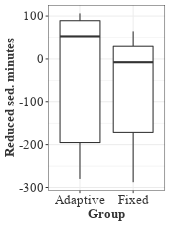

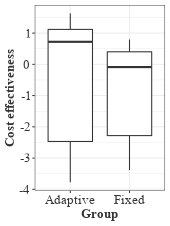

In [34]:
%%R -i DURATION -w 6 -h 8 -u cm

data <- DURATION %>% mutate(
    group=as.factor(if_else(group == 'stochastic', 'Adaptive', 'Fixed')),
    pid=as.factor(pid)
)

p_sed_dur <- ggplot(data, aes(x=group, y=diff)) +
    geom_boxplot() +
    THEME_DEFAULT +
    labs(
        x='Group',
        y='Reduced sed. minutes'
    ) + 
    scale_fill_grey()
    
p_cost_eff <- ggplot(data, aes(x=group, y=cost_eff)) +
    geom_boxplot() +
    THEME_DEFAULT +
    labs(
        x='Group',
        y='Cost effectiveness'
    ) + 
    scale_fill_grey()

ggsave('./output/lr-sed-dur.pdf', plot=p_sed_dur, width=6, height=8, units='cm', device=cairo_pdf)
ggsave('./output/lr-sed-dur-cost-eff.pdf', plot=p_cost_eff, width=6, height=8, units='cm', device=cairo_pdf)


print('-------- Sed. Dur during Baseline --------')
print(describeBy(control ~ group, data=data, trim=.2, digits=2, mat=TRUE))

print('-------- Sed. Dur during Intervention --------')
print(describeBy(intervention ~ group, data=data, trim=.2, digits=2, mat=TRUE))

print('-------- Reduced Sed. Dur --------')
print(describeBy(diff ~ group, data=data, trim=.2, digits=2, mat=TRUE))
print(by(data$diff, data$group, shapiro.test))
print(cohens_d(diff ~ group, data=data, pooled_sd = FALSE))
print(p_sed_dur)

print('\r\n-------- Cost. Eff --------')
print(describeBy(cost_eff ~ group, data=data, trim=.2, digits=5, mat=TRUE))
print(by(data$cost_eff, data$group, shapiro.test))
print(cohens_d(cost_eff ~ group, data=data, pooled_sd = FALSE))
print(p_cost_eff)

In [35]:
%R -n -i DURATION print(yuen(diff ~ group, data=DURATION, tr=0.2))
%R -n -i DURATION print(yuen(cost_eff ~ group, data=DURATION, tr=0.2))

Call:
yuen(formula = diff ~ group, data = DURATION, tr = 0.2)

Test statistic: 0.6276 (df = 18.13), p-value = 0.53807

Trimmed mean difference:  -39.84429 
95 percent confidence interval:
-173.1479     93.4593 

Explanatory measure of effect size: 0.16 

Call:
yuen(formula = cost_eff ~ group, data = DURATION, tr = 0.2)

Test statistic: 0.5552 (df = 18.86), p-value = 0.58525

Trimmed mean difference:  -0.45309 
95 percent confidence interval:
-2.1619     1.2557 

Explanatory measure of effect size: 0.14 



* As shown above, reduction of sedentary duration are greater in **the static group** than **stochastic group**.
* Yuen-Welch test also shows no significant differences.

### H2: Adherence Ratio

[1] "-------- Adhr. Ratio --------"
       item   group1 vars  n      mean        sd    median   trimmed       mad
ratio1    1 Adaptive    1 17 0.6092897 0.2205211 0.6078431 0.6214932 0.1418077
ratio2    2    Fixed    1 17 0.6577655 0.2360203 0.7407407 0.6975130 0.2361178
             min       max     range       skew   kurtosis        se
ratio1 0.1000000 0.9310345 0.8310345 -0.3993308 -0.3757327 0.0534842
ratio2 0.1009174 0.9318182 0.8309008 -0.8596763 -0.3066848 0.0572433
Cohen's d |        95% CI
-------------------------
-0.21     | [-0.88, 0.46]

- Estimated using un-pooled SD.data$group: Adaptive

	Shapiro-Wilk normality test

data:  dd[x, ]
W = 0.9531, p-value = 0.5073

------------------------------------------------------------ 
data$group: Fixed

	Shapiro-Wilk normality test

data:  dd[x, ]
W = 0.9047, p-value = 0.08145

[1] "\r\n-------- Cost. Eff --------"
          item   group1 vars  n      mean        sd    median   trimmed
cost_eff1    1 Adaptive    1 17 0.0005602 0.00

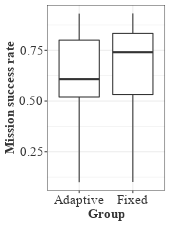

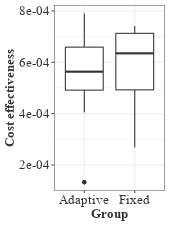

In [36]:
%%R -i ADHERENCE -w 6 -h 8 -u cm

data <- ADHERENCE %>% mutate(
    group=as.factor(if_else(group == 'stochastic', 'Adaptive', 'Fixed')),
    pid=as.factor(group)
)

p_adh <- ggplot(data, aes(x=group, y=ratio)) +
    geom_boxplot() +
    THEME_DEFAULT +
    labs(
        x='Group',
        y='Mission success rate'
    ) + 
    scale_fill_grey()

p_cost_eff <- ggplot(data, aes(x=group, y=cost_eff)) +
    geom_boxplot() +
    THEME_DEFAULT +
    labs(
        x='Group',
        y='Cost effectiveness'
    ) + 
    scale_fill_grey()

ggsave('./output/lr-occur-ratio.pdf', plot=p_adh, width=6, height=6, units='cm', device=cairo_pdf)
ggsave('./output/lr-occur-ratio-cost-eff.pdf', plot=p_cost_eff, width=6, height=6, units='cm', device=cairo_pdf)

print('-------- Adhr. Ratio --------')
print(describeBy(ratio ~ group, data=data, trim=.2, digits=7, mat=TRUE))
print(cohens_d(ratio ~ group, data=data, pooled_sd = FALSE))
print(by(data$ratio, data$group, shapiro.test))
print(p_adh)

print('\r\n-------- Cost. Eff --------')
print(describeBy(cost_eff ~ group, data=data, trim=.2, digits=7, mat=TRUE))
print(cohens_d(cost_eff ~ group, data=data, pooled_sd = FALSE))
print(by(data$cost_eff, data$group, shapiro.test))
print(p_cost_eff)

In [37]:
%R -n -i ADHERENCE print(t.test(ratio ~ group, data=ADHERENCE))
%R -n -i ADHERENCE print(t.test(cost_eff ~ group, data=ADHERENCE))


	Welch Two Sample t-test

data:  ratio by group
t = 0.61878, df = 31.853, p-value = 0.5405
alternative hypothesis: true difference in means between group fixed and group stochastic is not equal to 0
95 percent confidence interval:
 -0.1111290  0.2080806
sample estimates:
     mean in group fixed mean in group stochastic 
               0.6577655                0.6092897 


	Welch Two Sample t-test

data:  cost_eff by group
t = 0.49168, df = 31.714, p-value = 0.6263
alternative hypothesis: true difference in means between group fixed and group stochastic is not equal to 0
95 percent confidence interval:
 -8.152456e-05  1.333812e-04
sample estimates:
     mean in group fixed mean in group stochastic 
            0.0005860963             0.0005601680 



* As shown above, there is no statistically-significant difference of adherence ratio between different groups.

### H3: Motivation

       item     group1               group2 vars  n  mean   sd median trimmed
diff1     1      Fixed    Effort/Importance    1 17  1.13 1.05   1.00    1.07
diff2     2 Stochastic    Effort/Importance    1 17  0.76 0.91   0.80    0.84
diff3     3      Fixed   Interest/Enjoyment    1 17  0.88 1.55   0.57    0.73
diff4     4 Stochastic   Interest/Enjoyment    1 17 -0.06 0.94   0.14    0.05
diff5     5      Fixed     Perceived Choice    1 17  0.02 0.71   0.29    0.10
diff6     6 Stochastic     Perceived Choice    1 17 -0.14 0.72   0.00   -0.12
diff7     7      Fixed Perceived Competence    1 17  0.80 1.28   0.50    0.59
diff8     8 Stochastic Perceived Competence    1 17  0.34 0.87   0.33    0.23
diff9     9      Fixed     Pressure/Tension    1 17 -0.27 1.10  -0.40   -0.36
diff10   10 Stochastic     Pressure/Tension    1 17  0.09 1.23  -0.40   -0.20
diff11   11      Fixed     Value/Usefulness    1 17 -0.18 1.02  -0.14   -0.23
diff12   12 Stochastic     Value/Usefulness    1 17  0.09 0.58  

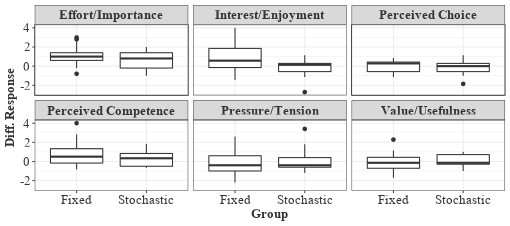

In [38]:
%%R -i IMI -w 18 -h 8 -u cm

data <- IMI %>% mutate(
    group=as.factor(if_else(group == 'stochastic', 'Stochastic', 'Fixed')),
    pid=as.factor(pid)
)

p <- ggplot(as.data.frame(data), aes(x=group, y=diff)) +
    geom_boxplot() +
    THEME_DEFAULT + 
    labs(
        x='Group',
        y='Diff. Response'
    ) + 
    facet_wrap(vars(subscale)) + 
    scale_fill_grey()

ggsave('./output/lr-imi.pdf', width=18, height=8, units='cm', device=cairo_pdf)

print(describeBy(diff ~ group + subscale, data=as.data.frame(data), trim=.2, digits=2, mat=TRUE))
print(by(data$diff, paste(data$subscale, '-', data$group), shapiro.test))
print(p)

* Interest/Enjoyment, Perceived Choice, and Pressure/Tension are not normal; so these measurements are analyzed by Yuen-Welch's t-test

In [39]:
%%R -i IMI

data <- as.data.frame(IMI)
subscale_abnormal = c('Interest/Enjoyment', 'Perceived Choice', 'Pressure/Tension')
data_abnormal <- data %>% filter(
    subscale %in% subscale_abnormal
)

data_normal <- data %>% filter(
    !(subscale %in% subscale_abnormal)
)

print(
    by(data_abnormal, data_abnormal$subscale, function(x) {
        return(yuen(diff ~ group, data=x, tr=0.2))
    })
)

print(
    by(data_normal, data_normal$subscale, function(x) {
        return(t.test(diff ~ group, data=x))
    })
)

data_abnormal$subscale: Interest/Enjoyment
Call:
yuen(formula = diff ~ group, data = x, tr = 0.2)

Test statistic: 1.6231 (df = 15.16), p-value = 0.12517

Trimmed mean difference:  0.67532 
95 percent confidence interval:
-0.2107     1.5613 

Explanatory measure of effect size: 0.47 

------------------------------------------------------------ 
data_abnormal$subscale: Perceived Choice
Call:
yuen(formula = diff ~ group, data = x, tr = 0.2)

Test statistic: 0.7466 (df = 18.55), p-value = 0.46464

Trimmed mean difference:  0.22078 
95 percent confidence interval:
-0.3991     0.8407 

Explanatory measure of effect size: 0.2 

------------------------------------------------------------ 
data_abnormal$subscale: Pressure/Tension
Call:
yuen(formula = diff ~ group, data = x, tr = 0.2)

Test statistic: 0.4398 (df = 19.99), p-value = 0.6648

Trimmed mean difference:  -0.16364 
95 percent confidence interval:
-0.9398     0.6125 

Explanatory measure of effect size: 0.11 

data_normal$subscale: E

### H4: Self-regulation

      item     group1      group2 vars  n  mean   sd median trimmed  mad   min
diff1    1      Fixed Amotivation    1 17 -0.18 1.16   0.00   -0.24 1.48 -1.67
diff2    2 Stochastic Amotivation    1 17  0.00 0.87   0.00    0.00 0.99 -1.67
diff3    3      Fixed  Autonomous    1 17  0.14 0.85   0.17    0.15 0.99 -1.17
diff4    4 Stochastic  Autonomous    1 17  0.34 0.86   0.33    0.33 0.74 -1.33
diff5    5      Fixed  Controlled    1 17  0.36 1.19   0.00    0.27 0.99 -2.17
diff6    6 Stochastic  Controlled    1 17 -0.15 1.01   0.00   -0.18 0.99 -1.83
       max range  skew kurtosis   se
diff1 2.00  3.67  0.21    -1.20 0.28
diff2 1.33  3.00 -0.02    -1.05 0.21
diff3 1.50  2.67 -0.08    -1.44 0.21
diff4 2.00  3.33  0.05    -0.69 0.21
diff5 3.17  5.33  0.39     0.49 0.29
diff6 1.67  3.50  0.15    -1.12 0.25
paste(data$subscale, "-", data$group): Amotivation - Fixed

	Shapiro-Wilk normality test

data:  dd[x, ]
W = 0.93234, p-value = 0.2381

----------------------------------------------------

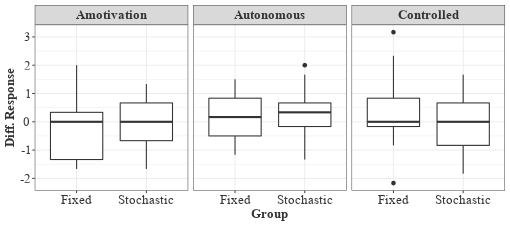

In [40]:
%%R -i SRQ -w 18 -h 8 -u cm

data <- SRQ %>% mutate(
    group=as.factor(if_else(group == 'stochastic', 'Stochastic', 'Fixed')),
    pid=as.factor(pid)
)

p <- ggplot(as.data.frame(data), aes(x=group, y=diff)) +
    geom_boxplot() +
    THEME_DEFAULT +
    labs(
        x='Group',
        y='Diff. Response'
    ) + 
    facet_wrap(vars(subscale)) + 
    scale_fill_grey()

ggsave('./output/lr-srq.pdf', width=18, height=8, units='cm', device=cairo_pdf)

print(describeBy(diff ~ group + subscale, data=as.data.frame(data), trim=.2, digits=2, mat=TRUE))
print(by(data$diff, paste(data$subscale, '-', data$group), shapiro.test))
print(p)

In [41]:
%%R -i SRQ -w 18 -h 12 -u cm

data <- SRQ

print(
    by(data, data$subscale, function(x) {
        return(t.test(diff ~ group, data=x))
    })
)

data$subscale: Amotivation

	Welch Two Sample t-test

data:  diff by group
t = -0.50223, df = 29.591, p-value = 0.6192
alternative hypothesis: true difference in means between group fixed and group stochastic is not equal to 0
95 percent confidence interval:
 -0.8944837  0.5415425
sample estimates:
     mean in group fixed mean in group stochastic 
           -1.764706e-01             9.832101e-18 

------------------------------------------------------------ 
data$subscale: Autonomous

	Welch Two Sample t-test

data:  diff by group
t = -0.69985, df = 31.998, p-value = 0.4891
alternative hypothesis: true difference in means between group fixed and group stochastic is not equal to 0
95 percent confidence interval:
 -0.8051066  0.3933419
sample estimates:
     mean in group fixed mean in group stochastic 
               0.1372549                0.3431373 

------------------------------------------------------------ 
data$subscale: Controlled

	Welch Two Sample t-test

data:  diff by gro

### H5: Habit Strength

      item     group1 vars  n mean   sd median trimmed  mad   min  max range
diff1    1      Fixed    1 17 0.38 1.12   0.33    0.33 0.49 -1.50 3.42  4.92
diff2    2 Stochastic    1 17 0.15 0.73   0.08    0.12 1.11 -0.83 1.33  2.17
      skew kurtosis   se
diff1 0.76     1.05 0.27
diff2 0.19    -1.46 0.18
data$group: Fixed

	Shapiro-Wilk normality test

data:  dd[x, ]
W = 0.92029, p-value = 0.1494

------------------------------------------------------------ 
data$group: Stochastic

	Shapiro-Wilk normality test

data:  dd[x, ]
W = 0.93034, p-value = 0.2205



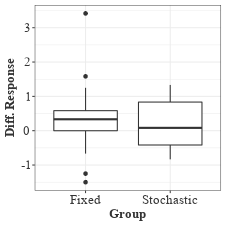

In [42]:
%%R -i HABIT -w 8 -h 8 -u cm

data <- HABIT %>% mutate(
    group=as.factor(if_else(group == 'stochastic', 'Stochastic', 'Fixed')),
    pid=as.factor(pid)
)

p <- ggplot(as.data.frame(data), aes(x=group, y=diff)) +
    geom_boxplot() +
    THEME_DEFAULT +
    labs(
        x='Group',
        y='Diff. Response'
    ) + 
    scale_fill_grey()

ggsave('./output/lr-habit.pdf', width=8, height=8, units='cm', device=cairo_pdf)

print(describeBy(diff ~ group, data=as.data.frame(data), trim=.2, digits=2, mat=TRUE))
print(by(data$diff, data$group, shapiro.test))
print(p)

In [43]:
%R -n -i ADHERENCE print(t.test(diff ~ group, data=HABIT))


	Welch Two Sample t-test

data:  diff by group
t = 0.70894, df = 27.563, p-value = 0.4843
alternative hypothesis: true difference in means between group fixed and group stochastic is not equal to 0
95 percent confidence interval:
 -0.4357730  0.8965573
sample estimates:
     mean in group fixed mean in group stochastic 
               0.3823529                0.1519608 



## Discussion

* Here, I discuss about why logistic-regression based intervention is failed.

In [44]:
MISSIONS_STOCHASTIC = MISSIONS_CLEAN.loc[
    lambda x: x['group'] == 'stochastic', 
]

MISSIONS_STOCHASTIC

,pid,date,incentive,state,prepare_time,stand_by_time,trigger_time,reaction_time,latitude,longitude,geo_hash,hour_name,is_weekend,group,start_date,days
4,P13,2020-05-06,-2.0,SUCCESS,1588740421306,1588742221326,1588743459845,1588743544329,36.368975,127.333106,wy6wcsc,AFTERNOON,False,stochastic,2020-04-28,8
5,P13,2020-05-06,-2.0,FAILURE,1588743620187,1588745420263,1588746620322,1588747359760,36.368976,127.333101,wy6wcsc,LATE AFTERNOON,False,stochastic,2020-04-28,8
6,P13,2020-05-06,-10.0,SUCCESS,1588750295191,1588752096115,1588753359912,1588753909511,36.368657,127.333555,wy6wcs9,LATE AFTERNOON,False,stochastic,2020-04-28,8
7,P13,2020-05-06,-2.0,SUCCESS,1588757570195,1588759370325,1588760570388,1588760614957,36.368976,127.333120,wy6wcsc,EVENING,False,stochastic,2020-04-28,8
8,P13,2020-05-06,-2.0,FAILURE,1588763836633,1588765636729,1588766837148,1588767438080,36.368807,127.333300,wy6wcs9,NIGHT,False,stochastic,2020-04-28,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,P11,2020-05-19,-2.0,FAILURE,1589852139148,1589853938206,1589855139124,1589855739189,37.298342,126.964543,wydk1ju,LATE MORNING,False,stochastic,2020-04-29,20
2383,P11,2020-05-19,-2.0,FAILURE,1589871385237,1589873439856,1589874639558,1589875239571,37.298465,126.964653,wydk1ju,LATE AFTERNOON,False,stochastic,2020-04-29,20
2384,P11,2020-05-19,-2.0,FAILURE,1589875239571,1589877039498,1589878240138,1589878840291,37.298465,126.964653,wydk1ju,LATE AFTERNOON,False,stochastic,2020-04-29,20
2385,P11,2020-05-19,-2.0,FAILURE,1589878840291,1589880640224,1589881839533,1589882439503,37.298465,126.964653,wydk1ju,EVENING,False,stochastic,2020-04-29,20


### Were LR models Built as Expected?

In [45]:
import numpy as np
from datetime import timedelta


MISSIONS_FIT = []

for pid in MISSIONS_STOCHASTIC['pid'].unique():
    d = MISSIONS_STOCHASTIC.loc[
        lambda x: x['pid'] == pid, :
    ].sort_values(
        'trigger_time'
    )
    
    lr = LogisticRegressionIncentive(
        incentives=np.arange(2, 21, 2),
        incentive_default=10,
        expected_likelihood=.51,
        window_size=10,
        random_state=None,
        allow_exploration=False
    )
    
    for i, row in enumerate(d.itertuples()):
        is_success = 1.0 if row.state == 'SUCCESS' else 0.0
        ctx = row.geo_hash
        inc = abs(row.incentive)
        res = lr.update(incentive=inc, response=is_success, context=ctx)
        if res:
            MISSIONS_FIT.append(
                {'pid': pid, 'round': i, 'coef_inc': lr.coef_incentive_, **res}
            )
        
MISSIONS_FIT = pd.DataFrame(MISSIONS_FIT).dropna()
MISSIONS_FIT

,pid,round,coef_inc,accuracy,logloss
0,P13,1,0.000000,0.500000,0.693147
1,P13,2,0.142156,0.666667,0.538011
2,P13,3,0.111015,0.750000,0.518542
3,P13,4,0.157464,0.600000,0.595540
4,P13,5,0.133747,0.666667,0.592697
...,...,...,...,...,...
774,P11,55,-0.210612,0.700000,0.437446
775,P11,56,-0.210368,0.700000,0.437432
776,P11,57,-0.210368,0.700000,0.437432
777,P11,58,-0.175084,0.800000,0.398405


In [61]:
MISSIONS_FIT.describe()

,round,coef_inc,accuracy,logloss
count,779.000000,779.000000,779.000000,779.000000
mean,32.681643,0.011175,0.764322,0.479830
std,21.903535,0.149047,0.122515,0.151077
min,1.000000,-0.438037,0.500000,0.062436
25%,15.000000,-0.075101,0.700000,0.325083
50%,28.000000,0.000000,0.800000,0.494427
75%,46.500000,0.109190,0.900000,0.607852
max,101.000000,0.384489,1.000000,0.693147


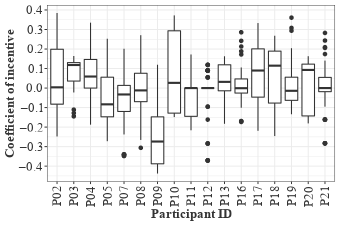

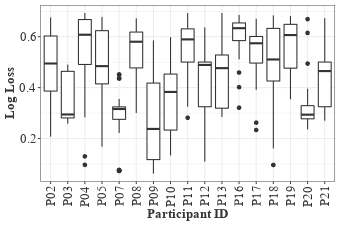

In [82]:
%%R -i MISSIONS_FIT -w 12 -h 8 -u cm


data <- MISSIONS_FIT

p_coef <- ggplot(data, aes(x=as.factor(pid), y=coef_inc)) +
    geom_boxplot() +
    THEME_DEFAULT +
    labs(
        x='Participant ID',
        y='Coefficient of incentive'
    ) +
    theme(
        axis.text.x=element_text(angle=90, vjust=.5)
    ) + 
    scale_y_continuous(
        breaks=c(-.4, -.3, -.2, -.1, 0, .1, .2, .3, .4),
        labels=c('\u20130.4', '\u20130.3', '\u20130.2', '\u20130.1', '0.0', '0.1', '0.2', '0.3', '0.4')
    )

p_loss <- ggplot(data, aes(x=as.factor(pid), y=logloss)) +
    geom_boxplot() +
    THEME_DEFAULT +
    labs(
        x='Participant ID',
        y='Log Loss'
    ) +
    theme(
        axis.text.x=element_text(angle=90, vjust=.5)
    )
    
print(p_coef)
print(p_loss)
ggsave('./output/lr-coef-subject.pdf', plot=p_coef, width=12, height=8, units='cm')
ggsave('./output/lr-loss-subject.png', plot=p_loss, width=12, height=8, units='cm')

In [47]:
MISSIONS_FIT.groupby('pid').mean().agg(
    lambda x: '{0[0]:.2f} (SD: {0[1]:.2f}; [{0[2]:.2f}, {0[3]:.2f}])'.format(stat(x))
)

round       27.60 (SD: 11.19; [21.85, 33.36])
coef_inc       0.00 (SD: 0.08; [-0.04, 0.04])
accuracy        0.78 (SD: 0.08; [0.74, 0.82])
logloss         0.46 (SD: 0.10; [0.40, 0.51])
dtype: object

In [48]:
print(f'Total Model Buildings: {len(MISSIONS_FIT)}/Negative Coef.: {len(MISSIONS_FIT.loc[lambda x: x["coef_inc"] < 0, :])}')

Total Model Buildings: 779/Negative Coef.: 380


* As shown above, our model's accuracy is moderate (0.77); however, coefficient for incentive was frequently estimated as negative. Actually, about the half of the model builidngs show the negative coefficient for the incentive.
* Therefore, we can conclude our assumption of monotonically-increasing behavior would be violated.

### Were Participants Sensitive to Incentive Size?

In [49]:
import pandas as pd


MISSIONS_GLMM = []

for pid in MISSIONS_STOCHASTIC['pid'].unique():
    sub = MISSIONS_STOCHASTIC.loc[
        lambda x: x['pid'] == pid, :
    ].sort_values(
        by='trigger_time'
    ).assign(
        round=lambda x: x['stand_by_time'].rank(method='dense').astype(int),
        days=lambda x: x['days'] - x['days'].min() + 1,
        incentive=lambda x: -x['incentive'],
        state=lambda x: (x['state'] == 'SUCCESS').astype(int)
    ).loc[
        :, ['pid', 'state', 'incentive', 'geo_hash', 'hour_name', 'days', 'is_weekend', 'round']
    ]
    
    freq_loc = sub.groupby(
        'geo_hash', as_index=False
    ).count().sort_values(
        'pid', ascending=True
    ).assign(
        freq=lambda x: x['pid'],
        rank=lambda x: x['freq'].rank(method='first').astype(int)
    ).assign(
        rank=lambda x: x['rank'].max() - x['rank'] + 1
    )[['geo_hash', 'freq', 'rank']]
    
    d = pd.merge(
        sub, freq_loc, on='geo_hash'
    )
    
    MISSIONS_GLMM.append(d)

MISSIONS_GLMM = pd.concat(MISSIONS_GLMM, axis=0)
MISSIONS_GLMM.to_csv('./proc/glmm_data.csv', index=None)
MISSIONS_GLMM.head()

,pid,state,incentive,geo_hash,hour_name,days,is_weekend,round,freq,rank
0,P13,1,2.0,wy6wcsc,AFTERNOON,1,False,1,36,1
1,P13,0,2.0,wy6wcsc,LATE AFTERNOON,1,False,2,36,1
2,P13,1,2.0,wy6wcsc,EVENING,1,False,4,36,1
3,P13,1,2.0,wy6wcsc,AFTERNOON,2,False,7,36,1
4,P13,0,2.0,wy6wcsc,LATE AFTERNOON,2,False,8,36,1


In [50]:
%%R -i MISSIONS_GLMM -w 12 -h 8 -u cm

data <- MISSIONS_GLMM %>% mutate(
    loc = if_else(rank <= 5, paste('Top-', rank, sep=''), 'Other'),
    loc = fct_other(loc, drop='Other'),
) %>% mutate(
    hour_name = fct_other(hour_name, drop='NIGHT'),
    is_weekend = fct_other(as_factor(is_weekend), drop=FALSE),
)

print(
    data %>% group_by(
        rank
    ) %>% summarise(
        n=n()
    ) %>% mutate(
        prop = n / sum(n),
        cum = cumsum(prop)
    )
)

# A tibble: 18 × 4
    rank     n    prop   cum
   <int> <int>   <dbl> <dbl>
 1     1   548 0.603   0.603
 2     2   140 0.154   0.757
 3     3    70 0.0770  0.834
 4     4    44 0.0484  0.882
 5     5    29 0.0319  0.914
 6     6    22 0.0242  0.938
 7     7    15 0.0165  0.955
 8     8     9 0.00990 0.965
 9     9     8 0.00880 0.974
10    10     6 0.00660 0.980
11    11     4 0.00440 0.985
12    12     4 0.00440 0.989
13    13     3 0.00330 0.992
14    14     2 0.00220 0.994
15    15     2 0.00220 0.997
16    16     1 0.00110 0.998
17    17     1 0.00110 0.999
18    18     1 0.00110 1    


#### Incentive + Location + Days

$$
\begin{aligned}
  \operatorname{state}_{i}  &\sim \operatorname{Binomial}(n = 1, \operatorname{prob}_{\operatorname{state} = 1} = \widehat{P}) \\
    \log\left[\frac{\hat{P}}{1 - \hat{P}} \right] &=\alpha_{j[i],k[i]} + \beta_{1}(\operatorname{incentive}) + \beta_{2}(\operatorname{loc}_{\operatorname{1}}) + \beta_{3}(\operatorname{loc}_{\operatorname{2}}) + \beta_{4}(\operatorname{loc}_{\operatorname{3}}) + \beta_{5}(\operatorname{loc}_{\operatorname{4}}) + \beta_{6}(\operatorname{loc}_{\operatorname{5}}) + \beta_{7}(\operatorname{days}) \\
    \alpha_{j}  &\sim N \left(\mu_{\alpha_{j}}, \sigma^2_{\alpha_{j}} \right)
    \text{, for loc:pid j = 1,} \dots \text{,J} \\
    \alpha_{k}  &\sim N \left(\mu_{\alpha_{k}}, \sigma^2_{\alpha_{k}} \right)
    \text{, for pid k = 1,} \dots \text{,K}
\end{aligned}
$$

In [51]:
%%R -o ht

m <- glmer(
    state ~ incentive + loc + days + (1 | pid/loc),
    data = data,
    family = 'binomial',
    contrasts=list(
        loc=contr.sum,
        hour_name=contr.sum,
        is_weekend=contr.treatment
    )
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: state ~ incentive + loc + days + (1 | pid/loc)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  1074.5   1122.7   -527.3   1054.5      899 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0128 -0.8269  0.4033  0.7321  2.5360 

Random effects:
 Groups  Name        Variance Std.Dev.
 loc:pid (Intercept) 0.3337   0.5777  
 pid     (Intercept) 1.0062   1.0031  
Number of obs: 909, groups:  loc:pid, 99; pid, 17

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.99512    0.36578   2.721  0.00652 **
incentive   -0.01965    0.01526  -1.288  0.19778   
loc1         0.23043    0.22032   1.046  0.29562   
loc2        -0.28505    0.25403  -1.122  0.26182   
loc3         0.14942    0.29880   0.500  0.61703   
loc4        -0.71430    0.33937  -2.105  0.03531 * 
loc5         0.69455    0.42318   1.641  0.10074

In [52]:
from IPython.core.display import HTML
HTML(ht[0])

#### Incentive + Location + Intervention Counts

In [53]:
%%R -o ht

m <- glmer(
    state ~ incentive + loc + round + (1 | pid/loc),
    data = data,
    family = 'binomial',
    contrasts=list(
        loc=contr.sum,
        hour_name=contr.sum,
        is_weekend=contr.treatment
    )
)

info <- summary(m)
contrasts <- attributes(model.matrix(m))$contrasts
tab <- tab_model(m, file='./output/temp.html')
ht <- tab$page.complete

print(info)
print(contrasts)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: state ~ incentive + loc + round + (1 | pid/loc)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  1078.2   1126.4   -529.1   1058.2      899 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7414 -0.8136  0.4092  0.7338  2.6490 

Random effects:
 Groups  Name        Variance Std.Dev.
 loc:pid (Intercept) 0.3788   0.6155  
 pid     (Intercept) 1.0085   1.0043  
Number of obs: 909, groups:  loc:pid, 99; pid, 17

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.765820   0.352058   2.175   0.0296 *
incentive   -0.018571   0.015403  -1.206   0.2279  
loc1         0.240881   0.225914   1.066   0.2863  
loc2        -0.272516   0.259241  -1.051   0.2932  
loc3         0.140385   0.303612   0.462   0.6438  
loc4        -0.718782   0.344404  -2.087   0.0369 *
loc5         0.681889   0.426728   1.598   0.11

In [54]:
from IPython.core.display import HTML
HTML(ht[0])

* Our GLMM analysis again shows adherence ratio is slightly decreased as incentive increases.

In [55]:
import numpy as np
import pandas as pd


TOY_SIMS = []
ARGS = dict(
    incentives=np.arange(2, 21, 2),
    incentive_default=10,
    expected_likelihood=.51,
    window_size=10,
    random_state=None,
    allow_exploration=False
)
lr = LogisticRegressionIncentive(**ARGS)
lr_init = LogisticRegressionIncentive(**ARGS)
lr_ran = LogisticRegressionIncentive(**ARGS)

b = lambda r: 1 / (1 + np.exp( (1 - 2 * ((r - 2) / 18) ) * np.log(99) ))
ran = np.random.default_rng(7)

for i in range(50):
    th = ran.uniform()
    
    inc = lr.choose()
    resp = 1.0 if th < b(inc) else 0.0
    lr.update(response=resp, incentive=inc)
    
    TOY_SIMS.append({
        'rounds': i,
        'incentives': inc,
        'responses': resp,
        'name': 'Ideal'
    })
    
    inc = lr_init.choose()
    resp = 1.0 if i < 7 or th < b(inc) else 0.0
    lr_init.update(response=resp, incentive=inc)
    
    TOY_SIMS.append({
        'rounds': i,
        'incentives': inc,
        'responses': resp,
        'name': 'Ideal w/ Init.'
    })
    
    inc = lr_ran.choose()
    resp = 1.0 if th < .5 else 0.0
    lr_ran.update(response=resp, incentive=inc)
    
    TOY_SIMS.append({
        'rounds': i,
        'incentives': inc,
        'responses': resp,
        'name': 'Random'
    })
    
TOY_SIMS = pd.DataFrame(TOY_SIMS)
TOY_SIMS

,rounds,incentives,responses,name
0,0,10,0.0,Ideal
1,0,10,1.0,Ideal w/ Init.
2,0,10,0.0,Random
3,1,20,1.0,Ideal
4,1,2,1.0,Ideal w/ Init.
...,...,...,...,...
145,48,2,0.0,Ideal w/ Init.
146,48,10,0.0,Random
147,49,10,0.0,Ideal
148,49,2,0.0,Ideal w/ Init.


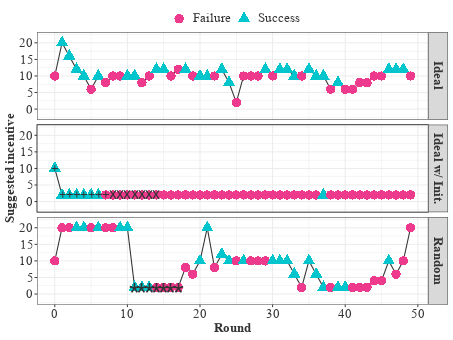

In [56]:
%%R -i TOY_SIMS -w 16 -h 12 -u cm

data <- TOY_SIMS %>% mutate(
    name=as_factor(name),
    responses=as_factor(if_else(responses == 1, 'Success', 'Failure'))
)

p <- ggplot(data, aes(x=rounds, y=incentives)) +
    geom_line(color='grey20') +
    geom_point(size=4, alpha=1.0, aes(shape = responses, colour = responses)) +
    geom_point(
        data=data %>% filter((rounds < 18) & (rounds > 10) & (name == 'Random')),
        aes(x=rounds, y = incentives),
        colour='grey20',
        shape='*',
        size=7
    ) +
    geom_point(
        data=data %>% filter((rounds <= 7) & (name == 'Ideal w/ Init.')),
        aes(x=rounds, y = incentives),
        colour='grey20',
        shape='+',
        size=3
    ) +
    geom_point(
        data=data %>% filter((rounds > 7) & (rounds < 15) & (name == 'Ideal w/ Init.')),
        aes(x=rounds, y = incentives),
        colour='grey20',
        shape='x',
        size=4
    ) +
    THEME_DEFAULT +
    labs(
        x='Round',
        y='Suggested incentive',
        shape='Response',
        color='Response'
    ) + 
    facet_grid(
        rows=vars(name)
    ) + 
    scale_y_continuous(
        limits=c(-2, 22)
    ) + 
    scale_colour_discrete(
        type=c('violetred2', 'turquoise3')
    ) + 
    theme(
        legend.position='top',
        legend.title=element_blank(),
        legend.text=element_text(vjust=.6),
        legend.background=element_blank(),
    )
    
ggsave('./output/lr-toy-example-problem.pdf', plot=p, width=16, height=10, units='cm', device=cairo_pdf)
print(p)

* As shown above, an amount of incentive is fluctuated by previous success or failures in **ideal** behavior.
* However, the amount of incentive is rarely changed in the **random** behavior after the 17-th round.
    * The data ranging from the 7 to 16th round which are used to built a LR model show more failures on the larger amount of incentive.
    * Therefore, the LR model is fitted as the negative effect of incentive on adherence.
    * To deal with this problem, **I should break the assumption that a user's adherence is proportional to an amount of incentive.**
* In addition, in Ideal /w Init. model, a user's behavior is assumed that adherence occurs regardless of amount of incentive for the first 6 rounds.
    * In such case, LR model is fitted like a user's adherence occurs with a small amount of incentive; therefore, the the small amount of incentive consecutively is suggested whenever a user fails to adhere to interventions for next rounds. 
    * This pattern is corrected at the 18-th round, where adherence does not occur at all.
    * This is because incentive estimation is highly dependent on the previous model fitting; therefore, the amount of incentive that the previous model cannot present may not appear in the future model.
    * To deal with this problem, **I should explore a user's adherence behavior with a variety of incentive**.